# Microsoft ML Twitter Sentiment Analysis Tutorial

1. [Overview](#Overview)
2. [Fitting Models That Identify Sentiment](#TwitterSentiment)
3. [What's Next?](#Next)

## <a id="Overview">1. OVERVIEW</a>

Microsoft Machine Learning, or Microsoft ML for short, is an R package within Microsoft R Services that includes powerful machine learning algorithms and associated tools. The tutorial is an introduction to Microsoft ML for data scientists who want to take advantage of its unique capabilities.  It is intended primarily for those who are comfortable with using Microsoft R Services for data science, and want to see an end-to-end example that uses Microsoft ML to carry out common data science tasks.

## <a id="TwitterSentiment">2. FITTING MODELS THAT IDENTIFY SENTIMENT</a>

The tutorial steps through the fitting of a model for identifying sentiment from Twitter text. Identifying how people feel about a product or an event is important to sales. We will focus on identifying which tweets identify happiness or sadness.

The tutorial begins from data imported from a twitter database. In this tutorial, the features are automatically extracted from the text using the featurizeText Microsoft ML transform. Then, a model is fit by multiple learning algorithms, and the performance of these fit models is compared to select the best one. The initial and final steps in this process will be familiar to Microsoft R Services users, while the model fitting and performance evaluation steps will involve new Microsoft ML commands.

### <a id="Packages">2.1. LOADING THE PACKAGES</a>

The tutorial is broken into steps, the first being loading the Microsoft ML package. When you execute the first step, there should be no output.

In [1]:
#-----------------------------------------------------------------------
# 1. Load packages.
#-----------------------------------------------------------------------
if (!suppressPackageStartupMessages(require("MicrosoftML",
                                            quietly = TRUE,
                                            warn.conflicts = FALSE))) {
    stop("The MicrosoftML package does not seem to be installed, so this\n",
         "script cannot be run. If Microsoft R Server with MML is installed,\n",
         "you may need to switch the R engine option. In R Tools for Visual\n",
         "Studio, this option is under:\n",
         "\tR Tools -> Options -> R Engine.\n",
         "If Microsoft R Server with MML is not installed, you can download it\n",
         "from https://microsoft.sharepoint.com/teams/TLC/SitePages/MicrosoftML.aspx\n")
}

### <a id="Import">2.2. IMPORT DATA</a>

The second step consists of importing the data we will use to fit a model. There is only one table of data: the HappyOrSad table. This section imports that table into an Xdf. These Xdfs are an efficient way of working with large amounts of data. They are files in which the rows are grouped in blocks whose size is specified by the parameter rowsPerBlock.

In [2]:
#-----------------------------------------------------------------------
# 2. Import data.
#-----------------------------------------------------------------------

# The directory containing data files.
dataDir <- file.path("Data")

# Verify that the data file exists.
if (!file.exists(file.path(dataDir, "HappyOrSad.csv"))) {
    stop("The data files needed for running this script cannot be found.\n",
         "You may need to set R's working directory to the location of the Data\n",
         "directory.")
}

# The data chunk size.
rowsPerBlock <- 1000000

The HappyOrSad table has one row per tweet, and three columns: id_nfpu, features, and label. Because the id_nfpu column uniquely identifies each tweet, it is ignored. The two remaining  columns are text, and they are respectively renamed Text and sentiment. As part of the importing process, we create Label, a logical variable that is TRUE when the sentiment is happiness, and false otherwise.

In [3]:
# The data source has three columns. Keep the tweet text and sentiment.
datasetSource <-
    RxTextData(file.path(dataDir, "HappyOrSad.csv"),
               varsToKeep = c("features", "label"),
               colInfo = list(features = list(type = "character",
                                              newName = "Text"),
                              label = list(type = "character",
                                           newName = "sentiment")),
               quotedDelimiters = TRUE)

# Import the data. Define Label.
dataset <-
    rxImport(datasetSource,
             transforms = list(Label = sentiment == "happiness"),
             outFile = tempfile(fileext = ".xdf"),
             rowsPerRead = rowsPerBlock)

Rows Read: 10362, Total Rows Processed: 10362, Total Chunk Time: 0.152 seconds 


We can see from the output that the activity table has 252,204 rows, and its first few rows are

In [4]:
head(dataset)

Text,sentiment,Label
Layin n bed with a headache ughhhh...waitin on your call...,sadness,FALSE
Funeral ceremony...gloomy friday...,sadness,FALSE
"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sadness,FALSE
@charviray Charlene my love. I miss you,sadness,FALSE
@kelcouch I'm sorry at least it's Friday?,sadness,FALSE
Ugh! I have to beat this stupid song to get to the next rude!,sadness,FALSE


### <a id="Split">2.3. SPLIT THE DATASET INTO TRAIN AND TEST</a>

To create train and test sets, the data are randomly split by tweet into two datasets. The training data tweets will be used by the learners to fit models, while the test data tweets  will be used as a fair measure the performance of the fit models. Because the split is randomized, we first set the random seed used by the randomizer to guarantee we will be able to reproduce our results at a later date.

In [5]:
#-----------------------------------------------------------------------
# 3. Split the dataset into train and test data.
#-----------------------------------------------------------------------
# Set the random seed for reproducibility of randomness.
set.seed(2345, "L'Ecuyer-CMRG")
# Randomly split the data 80-20 between train and test sets.
dataProb <- c(Train = 0.8, Test = 0.2)
dataSplit <-
    rxSplit(dataset,
            splitByFactor = "splitVar",
            transforms = list(splitVar =
                                sample(dataFactor,
                                       size = .rxNumRows,
                                       replace = TRUE,
                                       prob = dataProb)),
            transformObjects =
                list(dataProb = dataProb,
                     dataFactor = factor(names(dataProb),
                                         levels = names(dataProb))),
            outFilesBase = tempfile())

# Name the train and test datasets.
dataTrain <- dataSplit[[1]]
dataTest <- dataSplit[[2]]

Rows Read: 10362, Total Rows Processed: 10362Rows Read: 8279, Total Rows Processed: 8279, Total Chunk Time: 0.020 seconds 
Rows Read: 2083, Total Rows Processed: 2083, Total Chunk Time: 0.006 seconds 
, Total Chunk Time: 0.219 seconds 


We can explore the distribution of "Label" in the train and test sets.

In [6]:
rxSummary(~ Label, dataTrain)$sDataFrame
rxSummary(~ Label, dataTest)$sDataFrame

Rows Read: 8279, Total Rows Processed: 8279, Total Chunk Time: Less than .001 seconds 
Computation time: 0.002 seconds.


Name,Mean,StdDev,Min,Max,ValidObs,MissingObs
Label,0.5057374,0.4999973,0,1,8279,0


Rows Read: 2083, Total Rows Processed: 2083, Total Chunk Time: Less than .001 seconds 
Computation time: 0.003 seconds.


Name,Mean,StdDev,Min,Max,ValidObs,MissingObs
Label,0.4896783,0.5000135,0,1,2083,0


We read from the output that train has 8,279 rows while test has 2,083 rows. Because Label is a boolean, its mean shows the proportion of happy tweets in the data. We see that train has more than 50% happy tweets and that test has almost 49% happy tweets, which is a reasonable split.

### <a id="Model">2.4. DEFINE THE MODEL</a>

The model is a formula that describes what column has the label, and what columns are to be used to rxPredict the label. We will be using as rxPredictors features that will be automatically obtained from the Text column. Then we create a formula that says that Label is to be rxPredicted by these features.

In [7]:
#-----------------------------------------------------------------------
# 4. Define the model to be fit.
#-----------------------------------------------------------------------
# The model is a formula that says that sentiments are to be identified
# using Features, a stand-in for variables created on-the-fly from text
# by the text transform.
(model <- Label ~ Features)

Label ~ Features

The left-hand side of the formula is the label, while the right-hand side lists the source of the rxPredictors.

### <a id="Fit">2.5. FIT THE MODEL</a>

The model will be fit by learners that can rxPredict class data: rxLogisticRegression, rxFastLinear, rxFastTrees, rxFastForest, and rxNeuralNet. In the next section, each fit will be used to score the test data. The comments in this section give a glimpse of the kind of work done by each learner.

Each command has two mlTransforms. The featurizeText transform automatically creates text-based features from the tweets, while the selectFeatures transform sorts through the created features to include in the model those that are most informative about each tweet's label.

In [8]:
#-----------------------------------------------------------------------
# 5. Fit the model using different learners.
#-----------------------------------------------------------------------
# Fit the model with logistic regression. This finds the variable
# weights that are most useful for rxPredicting sentiment. The
# rxLogisticRegression learner automatically adjusts the weights to select
# those variables that are most useful for making rxPredictions.
rxLogisticRegressionFit <-
    rxLogisticRegression(model, data = dataTrain,
                       mlTransforms =
                           list(featurizeText(vars = c(Features = "Text")),
                                selectFeatures(model, mutualInformation())))

Beginning read for block: 1
Rows Read: 8279, Read Time: 0.007, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.007, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Computing mutual information
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.007, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.009, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.006, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Finished mutual information computation in 00:00:01.4135176
Selecting features to drop
Selected 1000 slots out of 15588 in column 'Features'
Total number of slots selected: 1000
Not adding a 

In [9]:
#-----------------------------------------------------------------------
# Fit the model with linear regression. This finds the variable
# weights that are most useful for rxPredicting sentiment. The
# rxFastLinear learner automatically adjusts the weights to select
# those variables that are most useful for making rxPredictions.
rxFastLinearFit <-
    rxFastLinear(model, data = dataTrain,
                  mlTransforms =
                    list(featurizeText(vars = c(Features = "Text")),
                         selectFeatures(model, mutualInformation())))

Beginning read for block: 1
Rows Read: 8279, Read Time: 0.006, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.006, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Computing mutual information
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.006, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.007, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.005, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Finished mutual information computation in 00:00:01.2399867
Selecting features to drop
Selected 1000 slots out of 15588 in column 'Features'
Total number of slots selected: 1000
Not adding a 

In [10]:
#-----------------------------------------------------------------------
# Fit the model with boosted trees. This finds the combinations of
# variables and threshold values that are useful for rxPredicting sentiment.
# The rxFastTrees learner automatically builds a sequence of trees so that
# trees later in the sequence repair errors made by trees earlier in the
# sequence.
rxFastTreesFit <-
    rxFastTrees(model, data = dataTrain,
               mlTransforms =
                    list(featurizeText(vars = c(Features = "Text")),
                         selectFeatures(model, mutualInformation())),
               randomSeed = 23648)

Beginning read for block: 1
Rows Read: 8279, Read Time: 0.008, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.007, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Computing mutual information
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.007, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.008, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.006, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Finished mutual information computation in 00:00:01.3049749
Selecting features to drop
Selected 1000 slots out of 15588 in column 'Features'
Total number of slots selected: 1000
Not adding a 

In [11]:
#-----------------------------------------------------------------------
# Fit the model with random forest. This finds the combinations of
# variables and threshold values that are useful for rxPredicting sentiment.
# The rxFastForest learner automatically builds a set of trees whose
# combined rxPredictions are better than the rxPredictions of any one of the
# trees.
rxFastForestFit <-
    rxFastForest(model, data = dataTrain,
                 mlTransforms =
                    list(featurizeText(vars = c(Features = "Text")),
                         selectFeatures(model, mutualInformation())),
                 randomSeed = 23648)

Beginning read for block: 1
Rows Read: 8279, Read Time: 0.005, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.006, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Computing mutual information
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.006, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.009, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.005, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Finished mutual information computation in 00:00:01.2482423
Selecting features to drop
Selected 1000 slots out of 15588 in column 'Features'
Total number of slots selected: 1000
Not adding a 

In [12]:
#-----------------------------------------------------------------------
# Fit the model with neural net. This finds the variable weights that
# are most useful for rxPredicting sentiment. Neural net can excel when
# dealing with non-linear relationships between the variables.
rxNeuralNetFit <-
    rxNeuralNet(model, data = dataTrain,
                mlTransforms =
                    list(featurizeText(vars = c(Features = "Text")),
                         selectFeatures(model, mutualInformation())))

Beginning read for block: 1
Rows Read: 8279, Read Time: 0.007, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.005, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Computing mutual information
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.009, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.008, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 8279, Read Time: 0.006, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Finished mutual information computation in 00:00:01.2677761
Selecting features to drop
Selected 1000 slots out of 15588 in column 'Features'
Total number of slots selected: 1000
Not adding a 

### <a id="Score">2.6. SCORE THE TEST DATA</a>

Each fit will be used to score the test data.  In order to plot together each fit's performance for convenient side-by-side comparison, we append each rxPrediction column to the test dataset. This will also conveniently include the Label column with the rxPredictions, so that the rxPrediction performance can be computed. When the test data are huge, scoring in this manner may not be possible. In that case, each rxPrediction set will have to be computed separately, and then merged into one data table.

In [13]:
#-----------------------------------------------------------------------
# 6. Score the held-aside test data with the fit models.
#-----------------------------------------------------------------------
# The scores are each test record's probability of being a sentiment.
# This combines each fit model's rxPredictions and the label into one
# table for side-by-side plotting and comparison.
fitScores <-
    rxPredict(rxLogisticRegressionFit, dataTest, suffix = ".rxLogisticRegression",
            extraVarsToWrite = names(dataTest),
            outData = tempfile(fileext = ".xdf"))
fitScores <-
    rxPredict(rxFastLinearFit, fitScores, suffix = ".rxFastLinear",
            extraVarsToWrite = names(fitScores),
            outData = tempfile(fileext = ".xdf"))
fitScores <-
    rxPredict(rxFastTreesFit, fitScores, suffix = ".rxFastTrees",
            extraVarsToWrite = names(fitScores),
            outData = tempfile(fileext = ".xdf"))
fitScores <-
    rxPredict(rxFastForestFit, fitScores, suffix = ".rxFastForest",
            extraVarsToWrite = names(fitScores),
            outData = tempfile(fileext = ".xdf"))
fitScores <-
    rxPredict(rxNeuralNetFit, fitScores, suffix = ".rxNeuralNet",
            extraVarsToWrite = names(fitScores),
            outData = tempfile(fileext = ".xdf"))

Beginning read for block: 1
Rows Read: 2083, Read Time: 0.002, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.3493465
Finished writing 2083 rows.
Writing completed.
Beginning read for block: 1
Rows Read: 2083, Read Time: 0.002, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.2835029
Finished writing 2083 rows.
Writing completed.
Beginning read for block: 1
Rows Read: 2083, Read Time: 0.002, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.4074182
Finished writing 2083 rows.
Writing completed.
Beginning read for block: 1
Rows Read: 2083, Read Time: 0.002, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.3653417
Finished writing 2083 rows.
Writing completed.
Beginning read for block: 1
Rows Read: 2083, Read Time: 0.002, T

We see in the output of the command that the number of rows in the results is the same as the number of rows in the test data.

### <a id="Compare">2.7. COMPARE THE FIT MODEL PERFORMANCE</a>

For each fit model, its rxPredictions and the Label are used to compute an ROC curve for that fit. The curves will then be plotted side-by-side in a graph.

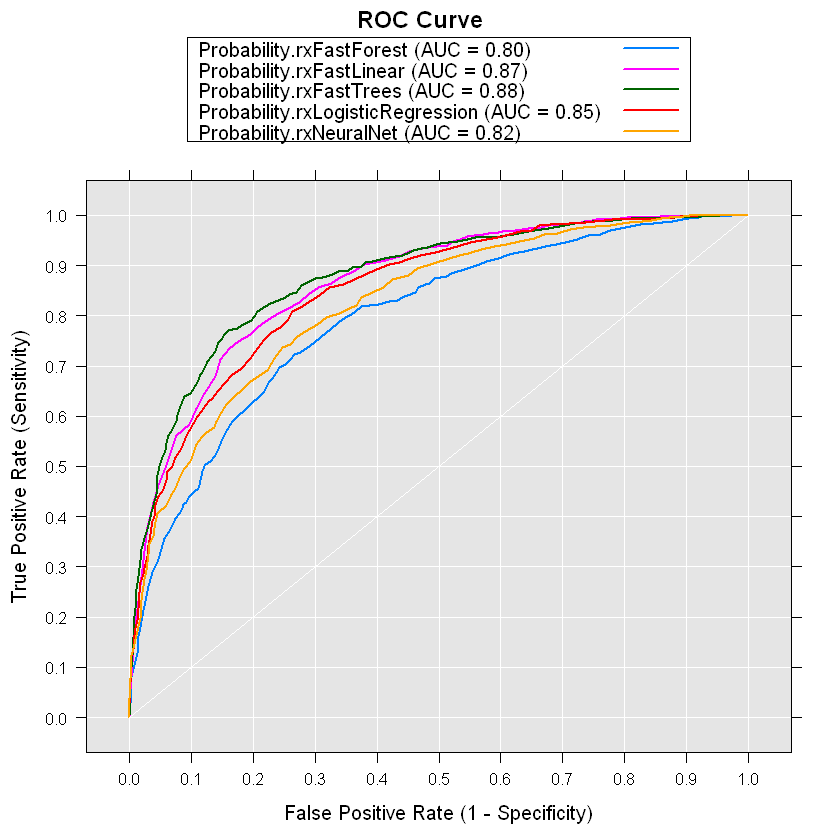

In [14]:
#-----------------------------------------------------------------------
# 7. Compare the performance of fit models.
#-----------------------------------------------------------------------
# Compute the fit models's ROC curves.
fitRoc <-
    rxRoc("Label",
          paste("Probability",
                 c("rxLogisticRegression", "rxFastLinear", "rxFastTrees",
                   "rxFastForest", "rxNeuralNet"),
                 sep = "."),
          fitScores)
# Plot the ROC curves and report their AUCs.
plot(fitRoc)

The fit models are then used to compute the fit model AUCs, and these are used to select the best model.

In [15]:
# Create a named list of the fit models.
fitList <-
    list(rxLogisticRegression = rxLogisticRegressionFit,
         rxFastLinear = rxFastLinearFit,
         rxFastTrees = rxFastTreesFit,
         rxFastForest = rxFastForestFit,
         rxNeuralNet = rxNeuralNetFit)

# Compute the fit models's AUCs.
fitAuc <- rxAuc(fitRoc)
names(fitAuc) <- substring(names(fitAuc), nchar("Probability.") + 1)

# Find the name of the fit with the largest AUC.
bestFitName <- names(which.max(fitAuc))

# Select the fit model with the largest AUC.
bestFit <- fitList[[bestFitName]]

# Report the fit AUCs.
cat("Fit model AUCs:\n")
print(fitAuc, digits = 2)

# Report the best fit.
cat(paste0("Best fit model with ", bestFitName,
           ", AUC = ", signif(fitAuc[[bestFitName]], digits = 2),
           ".\n"))

Fit model AUCs:
        rxFastForest         rxFastLinear          rxFastTrees 
                0.80                 0.87                 0.88 
rxLogisticRegression          rxNeuralNet 
                0.85                 0.82 
Best fit model with rxFastTrees, AUC = 0.88.


In the end, the best fit model is stored in variable bestFit.

## <a id="Next">3. WHAT'S NEXT?</a>

In the Microsoft ML samples directory, the script TwitterSentiment.R contains all the R code used in this tutorial. It also contains other scripts formatted to follow the steps used for retail churn. Try them out interactively, and learn about other Microsoft ML capabilities.